In [1]:
from __future__ import division

from utils.prog import log_progress as lp
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
import scipy.stats as stats
import sklearn.cluster
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import scipy
import sys
import os
sys.stdout.write('.')
%matplotlib inline

%load_ext rpy2.ipython

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

CONDIR = os.environ.get("CONDIR")

.

In [2]:
connectomes_gsr_all = np.load(os.path.join(CONDIR,'derivatives/connectomes_gsr.npy'))
connectomes_all = np.load(os.path.join(CONDIR,'derivatives/connectomes.npy'))
results_all = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'))
results_all = results_all.drop('Unnamed: 0',axis=1)
cleantable = pd.read_csv(os.environ.get("CLEANTABLE"))

for idx,row in results_all.iterrows():
    subid = np.where(row.subject==cleantable.UID)
    results_all.set_value(idx,'MRIQC_score',list(cleantable.MRIQC_score.iloc[subid])[0])


### Get within network connectivity

In [3]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"04_connectome/utils/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = range(333,353)
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*20+['cerebellum']*27
labels = np.unique(labelnames)
labelnames_unsorted = list(labeltable.Community)+['subcort']*20+['cerebellum']*27

def get_within_network_connectivity(con):
    con_av = np.zeros([len(labels),len(labels),con.shape[2]])
    idx1 = -1
    for label1 in lp(labels):
        idx1 += 1
        for idx2,label2 in enumerate(labels):
            x1 = np.where(np.array(labelnames_unsorted) == label1)[0]
            x2 = np.where(np.array(labelnames_unsorted) == label2)[0]
            subsel = con[x1,:,:]
            subsel = subsel[:,x2,:]
            if label1==label2: #if within-network connectivity: only average top triangle
                upid = np.triu_indices(len(x1))
                av = np.mean(subsel[upid],axis=0)
            else:
                av = np.mean(subsel,axis=(0,1))
            con_av[idx1,idx2,:] = av
    return con_av

con_av_gsr_all = get_within_network_connectivity(connectomes_gsr_all)
con_av_all = get_within_network_connectivity(connectomes_all)

### Summarise over subjects

In [4]:
QAid = np.where(results_all.MOTION_pass==1)[0]
results = results_all.iloc[QAid]
results['patient_bin'] = ['True' if x==888 else 'False' for x in results['patient']]
results.reset_index()
con_av = con_av_all[:,:,QAid]
con_av_gsr = con_av_gsr_all[:,:,QAid]

MRIQCid = np.where(np.logical_and(results_all.MOTION_pass==1,results_all.MRIQC_pass==1))[0]
results_qc = results_all.iloc[MRIQCid]
results_qc['patient_bin'] = ['True' if x==888 else 'False' for x in results_qc['patient']]
results_qc.reset_index()
con_av_qc = con_av_all[:,:,MRIQCid]
con_av_gsr_qc = con_av_gsr_all[:,:,MRIQCid]

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
def reduce_subjects(connectomes,subjects):
    consub = np.zeros([15,15,len(np.unique(subjects))])
    patient = []; weights = []; ncon = []
    it = 0
    for subject in np.unique(subjects):
        cleanid = np.where(subject==cleantable.UID)[0][0]
        cleanrow = cleantable.iloc[cleanid]
        patient.append(1 if cleanrow.is_this_subject_a_patient==888 else 0)
        conid = np.where(subject==subjects)[0]
        con = con_av[:,:,conid]
        consub[:,:,it] = np.mean(con,axis=2)
        ncon.append(con.shape[2])
        weights.append(np.mean(np.var(con,axis=2)))
        it += 1
    weights = np.array(weights)/np.exp(np.array(ncon))
    weights = 1-weights/np.max(weights)
    return consub, patient, weights

consub_qc, patient_qc, weights_qc = reduce_subjects(con_av_qc,np.array(results_qc.subject))
consub, patient, weights = reduce_subjects(con_av,np.array(results.subject))

In [6]:
upid = np.triu_indices(15)
X_networks_qc = np.transpose(consub_qc[upid])
Y_networks_qc = np.array(patient_qc)
X_networks = np.transpose(consub[upid])
Y_networks = np.array(patient)

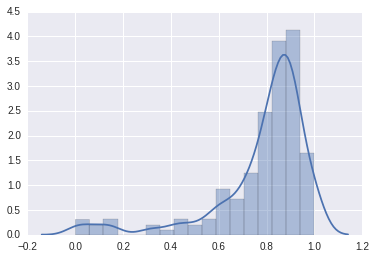

In [7]:
sns.distplot(weights)

In [8]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def compute_roc(X_init,Y_init,classifier,cv,weights):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_init, Y_init):
        # fit
        ft = classifier.fit(X_init[train], Y_init[train],sample_weight=weights[train])
        if hasattr(ft,'predict_proba'):
            probas_ = ft.predict_proba(X_init[test])
        else:
            probas_ = ft.decision_function(X_init[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_init[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1
    
    return mean_fpr,tprs,aucs

In [9]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold

K = 10
cv = StratifiedKFold(n_splits=K,shuffle=True,random_state = np.random.choice(2**32))
classifier = SVC(random_state=np.random.choice(2**32),kernel='linear',class_weight='balanced')

mean_fpr,tprs,aucs = compute_roc(X_networks,Y_networks,classifier,cv,weights=weights)

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


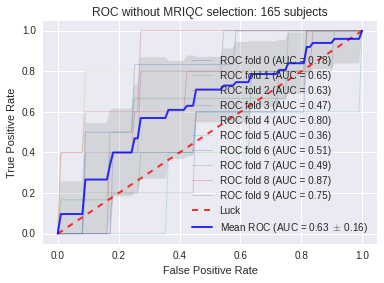

In [10]:
def roc_figure(mean_fpr,tprs,aucs,title='ROC'):
    K = len(tprs)
    for k in range(K):
        plt.plot(mean_fpr,tprs[k],lw=1,alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (k, aucs[k]))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

roc_figure(mean_fpr,tprs,aucs,title="ROC without MRIQC selection: %s subjects"%(X_networks.shape[0]))

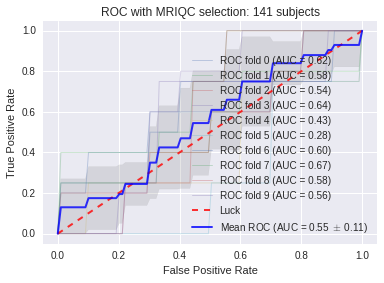

In [11]:
mean_fpr,tprs,aucs = compute_roc(X_networks_qc,Y_networks_qc,classifier,cv,weights=weights_qc)
roc_figure(mean_fpr,tprs,aucs,title="ROC with MRIQC selection: %s subjects"%(X_networks_qc.shape[0]))